In [1]:
import numpy as np
from scipy import signal
%matplotlib widget
import matplotlib.pyplot as plt
sys.path.insert(0, '../../drlib')
import drlib as dr


In [2]:
antData = np.load('./run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termData = np.load('./run1_termData_avgAll11776Spectra_gitignore.npy')[1:]
freqs = np.load('./run1_freqData_avgAll11776Spectra_gitignore.npy')



In [3]:
# Sampling rate such that the total amount of data is 1s
fs = len(freqs)

# Cutoff in number of bins
fc = 30

# Normalize the frequency in term of Nyquist
fcNorm = 2./(fc)

# Create a 6th-order Butterworth filter - returns numerator (b) and denominator (a) polynomials of the IIR filter
b, a = signal.butter(6, fcNorm, 'highpass', analog = False)

# Compute the frequency response of a digital filter.
# w: The frequencies at which h was computed, in the same units as fs.
# h: The frequency response, as complex numbers.
w, h = signal.freqz(b, a, worN=16384)
binNumberAxis = np.linspace(6000, 2, len(w))

filteredAntData = signal.filtfilt(b, a, antData)
filteredTermData = signal.filtfilt(b, a, termData)

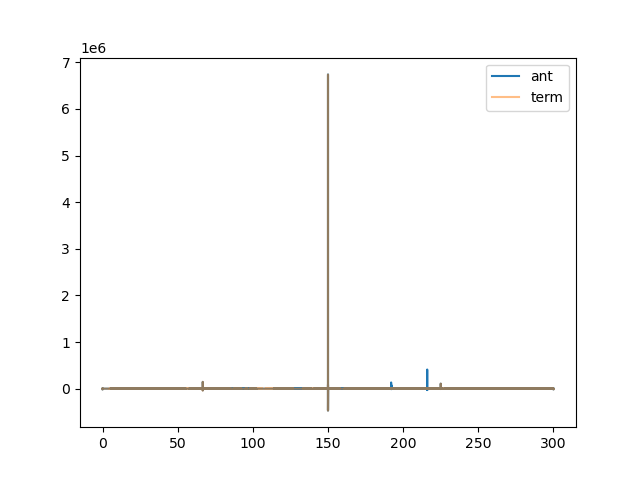

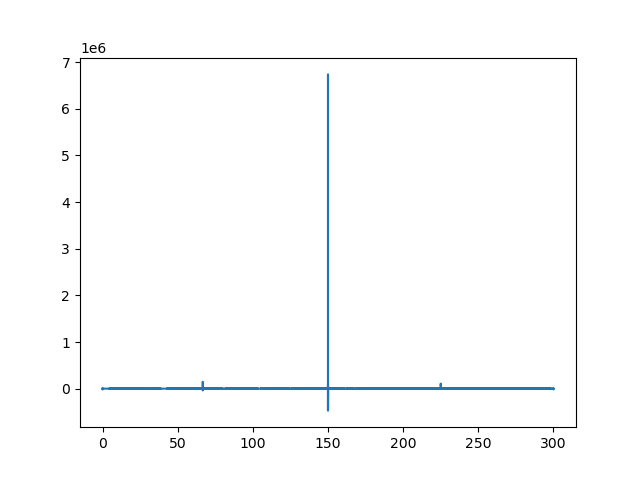

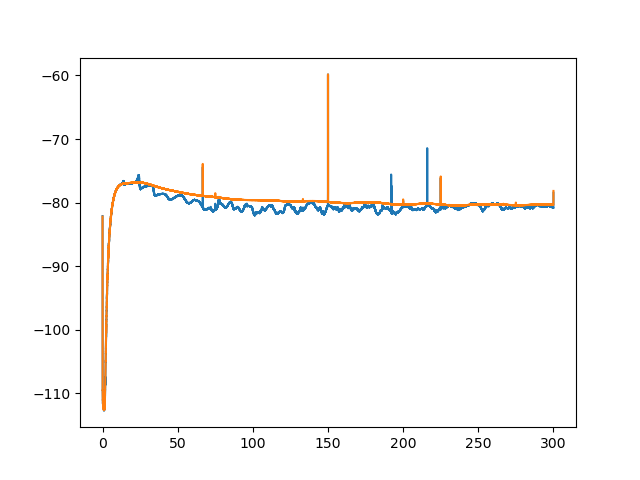

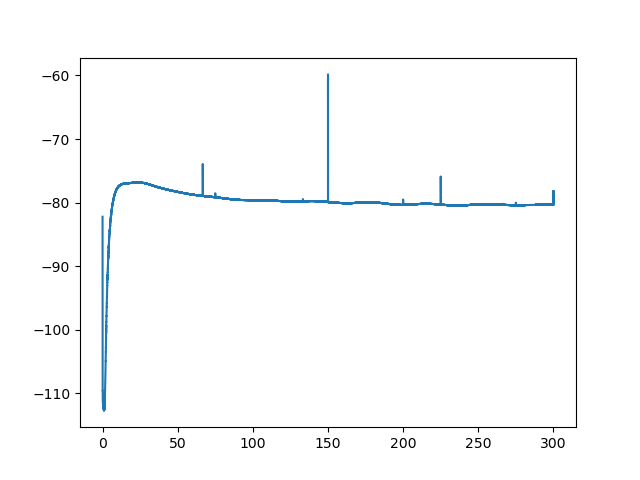

In [8]:
plt.close('all')
plt.figure()
plt.plot(freqs, filteredAntData, label = 'ant')
plt.plot(freqs, filteredTermData, alpha = .5, label = 'term')
plt.legend()

plt.figure()
plt.plot(freqs, filteredTermData)

plt.figure()
plt.plot(freqs, dr.fft2dBm(antData))
plt.plot(freqs, dr.fft2dBm(termData))

plt.figure()
plt.plot(freqs, dr.fft2dBm(termData))

In [10]:

#plt.close('all')

numSpans = 1
fmin = 50 #MHz
fmax = 300 #MHz
deltaf = fmax - fmin
spanWidth = deltaf / numSpans
overlapFactor = 0.00
searchSigma = 10
candidates = []
termCandidates = []

for spanidx in range(numSpans):
    spanMin = fmin + (spanWidth * spanidx)
    spanMax = fmin + (spanWidth * (spanidx + 1))
    spanMin -= spanMin * overlapFactor
    spanMax += spanMax * overlapFactor
    if spanMax > fmax: 
        spanMax = fmax
    if spanMin < fmin: 
        spanMin = fmin

    #compute bin number
    binSpanMin = int(spanMin/fmax * fs)
    binSpanMax = int(spanMax/fmax * fs)

    spanMean = filteredAntData[binSpanMin : binSpanMax].mean()
    spanStd = filteredAntData[binSpanMin : binSpanMax].std()
    threshold = spanMean + (searchSigma * spanStd)


    termSpanMean = filteredTermData[binSpanMin : binSpanMax].mean()
    termSpanStd = filteredTermData[binSpanMin : binSpanMax].std()
    termThreshold = termSpanMean + (searchSigma * termSpanStd)

    '''
    print('mean', spanMean)
    print('std', spanStd)
    print('thresh', threshold)
    '''
    
    candidates.append((filteredAntData[binSpanMin:binSpanMax] > threshold).sum())
    termCandidates.append((filteredTermData[binSpanMin:binSpanMax] > termThreshold).sum())

    #print('candidates found in span = ', candidates)

    #print each span's frequency and bin
    if 0:
        print('freq range = ', spanMin, spanMax)
        print('bin index range = ', binSpanMin, binSpanMax)
    
    #plot each span (can make many plots!)
    if 0:
        plt.figure()
        plt.plot(freqs[binSpanMin : binSpanMax], dr.fft2dBm(antData[binSpanMin : binSpanMax]))
        plt.xlabel('Freq (MHz)')
        plt.ylabel('Power (dBm)')

print(np.asarray(candidates).sum())
print('term candidates = ', termCandidates)


35
term candidates =  [30]


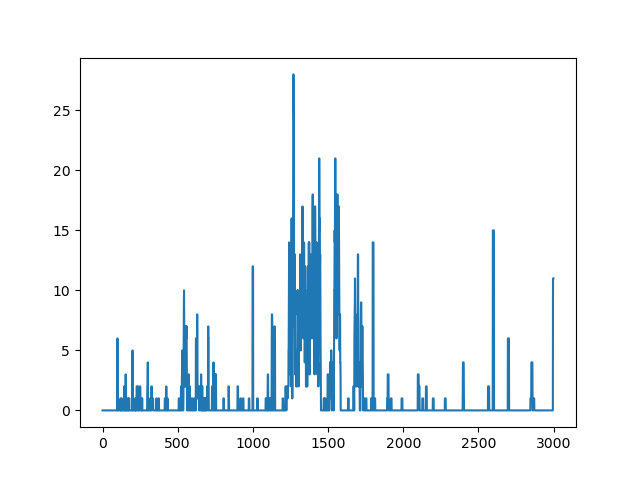

In [66]:
plt.figure()
plt.plot(candidates)